# Model Exploration

## Imports <a name="imports"></a>

In [1]:
#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

#Regression Metrics
from sklearn.metrics import mean_squared_error

#Classification Models
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

#XGBoost
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import PredictionError
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

import datetime

## Import Data <a name="importData"></a>

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

In [3]:
full_df.head()

,Date,Hour,Nieuwmarkt Arrivals,Nieuwezijds Kolk Arrivals,Dam Arrivals,Spui Arrivals,Nieuwmarkt Departures,Nieuwezijds Kolk Departures,Dam Departures,Spui Departures,...,SensorLatitude,CrowdednessCount,is_event,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2018-03-11,2400,77.0,38.0,187.0,40.0,198.0,63.0,411.0,87.0,...,6,0,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-2.449294e-16,1.000000
1,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,0,21,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,0.707107
2,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,9,88,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,0.707107
3,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,2,49,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,0.707107
4,2018-03-11,2200,116.0,64.0,288.0,21.0,210.0,103.0,732.0,98.0,...,8,2900,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-5.000000e-01,0.866025


## Sensor Dict
Dict with the labels of all the given sensors. This changes with each new DF construction

In [4]:
sensor_dict = {}
sensors = full_df.Sensor.unique()

for sensor in sensors:
    temp_df = full_df[full_df["Sensor"] == sensor].reset_index()
    
    sensor_dict[sensor] = {"Lat": temp_df["SensorLatitude"][0], "Lon": temp_df["SensorLongitude"][0]}

In [5]:
sensor_dict

{'GAWW-02': {'Lat': 6, 'Lon': 7},
 'GAWW-08': {'Lat': 0, 'Lon': 0},
 'GAWW-09': {'Lat': 9, 'Lon': 5},
 'GAWW-10': {'Lat': 2, 'Lon': 6},
 'GAWW-01': {'Lat': 8, 'Lon': 8},
 'GAWW-03': {'Lat': 4, 'Lon': 1},
 'GAWW-04': {'Lat': 5, 'Lon': 3},
 'GAWW-05': {'Lat': 1, 'Lon': 2},
 'GAWW-06': {'Lat': 3, 'Lon': 4},
 'GAWW-07': {'Lat': 7, 'Lon': 9}}

### Visualization

In [6]:
x = full_df.drop(["CrowdednessCount", "Date", "Hour", "Sensor"], axis=1)
y = full_df["CrowdednessCount"]

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


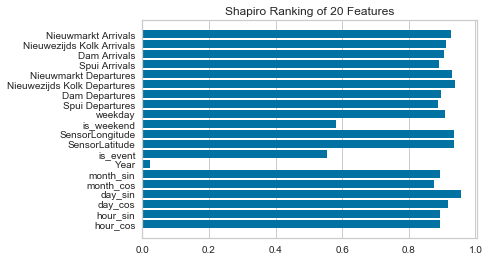

In [7]:
#Rank features - 1D
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

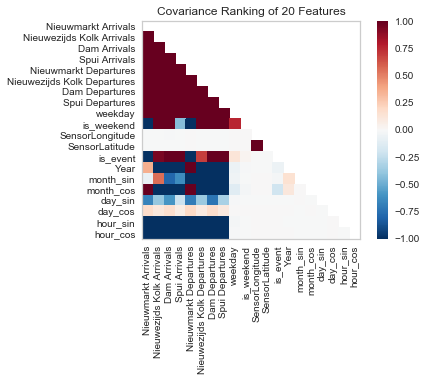

In [8]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

### Split Data into Training/Test and Time Series data

In [9]:
split_date = pd.Timestamp(2018, 12, 31)

TrainTest_df = full_df[full_df["Date"] <= split_date].reset_index().drop(columns=["index", "Hour", "Sensor", "Year"])
TimeSeries_df = full_df[full_df["Date"] > split_date].reset_index().drop(columns=["index", "Hour", "Sensor", "Year"])

### Criteria for train and test Model <a name="testModel"></a>
Divide set based on dates

In [10]:
all_dates = TrainTest_df["Date"].values
np.random.shuffle(all_dates)

split_dates = int(all_dates.size * 0.9)
train_set_dates = all_dates[:split_dates]
test_set_dates = all_dates[split_dates:]

Test only on selected sensor

In [11]:
test_sensor = "GAWW-02"

test_lat = sensor_dict[test_sensor]["Lat"]

Select start and end period evaluation

In [12]:
eval_start_date = pd.Timestamp(2019, 1, 1)
eval_end_date = pd.Timestamp(2019, 1, 31)

## Regression Models <a name="regModels"></a>

### Train, Test, Evaluation Split

In [13]:
train_df_reg = TrainTest_df[TrainTest_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date","index"])

test_df_reg = TrainTest_df[TrainTest_df["Date"].isin(test_set_dates)].reset_index().drop(columns=["index"])

In [14]:
#Train
x_train_reg = train_df_reg.drop(["CrowdednessCount"], axis=1)
y_train_reg = train_df_reg["CrowdednessCount"]

#Test
x_test_reg = test_df_reg.drop(["CrowdednessCount", "Date"], axis=1)
y_test_reg = test_df_reg["CrowdednessCount"]

test_reg_series = test_df_reg[(test_df_reg["SensorLatitude"] == test_lat) & 
                              (test_df_reg["Date"] == test_set_dates[0])].reset_index()
x_test_reg_series = test_reg_series.drop(["CrowdednessCount", "Date", "index"], axis=1)
y_test_reg_series = test_reg_series["CrowdednessCount"]

#Timeseries
x_eval_reg = TimeSeries_df.drop(["CrowdednessCount", "Date"], axis=1)
y_eval_reg = TimeSeries_df["CrowdednessCount"]

#Subset timeseries
sub_series = TimeSeries_df[(TimeSeries_df["SensorLatitude"] == test_lat) & 
                           (TimeSeries_df["Date"] >= eval_start_date) & 
                           (TimeSeries_df["Date"] <= eval_end_date)].reset_index()

#Time series
x_series_reg = sub_series.drop(["Date","CrowdednessCount", "index"], axis=1)
y_series_reg = sub_series["CrowdednessCount"]


feature_labels_reg = train_df_reg.columns.values

### Linear Regression <a name="regBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [15]:
#Give parameters model
reg_base = LinearRegression()

In [16]:
#Fit the model
reg_base.fit(x_train_reg, y_train_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Test

In [17]:
reg_base_score = reg_base.score(x_test_reg, y_test_reg)

y_pred_reg_base = reg_base.predict(x_test_reg)
base_reg_mse = mean_squared_error(y_pred_reg_base, y_test_reg)

print("R^2 Score: ", reg_base_score)
print("MSE: ", base_reg_mse)
print("RMSE: ", np.sqrt(base_reg_mse))

R^2 Score:  0.3284402553322785
MSE:  720219.6879664841
RMSE:  848.6575799263707


In [18]:
for i in range(10):
    print("Predicted: ", y_pred_reg_base[i], "Real: ", y_test_reg[i])

Predicted:  1466.4916331120958 Real:  0
Predicted:  1094.9989491650913 Real:  21
Predicted:  1410.6060585435944 Real:  88
Predicted:  1674.8963773348614 Real:  49
Predicted:  1691.0787451287833 Real:  2900
Predicted:  1632.5293436375268 Real:  0
Predicted:  1052.6319154677572 Real:  83
Predicted:  1238.3110242169391 Real:  822
Predicted:  1225.4818265701301 Real:  2661
Predicted:  1388.3008333970888 Real:  3291


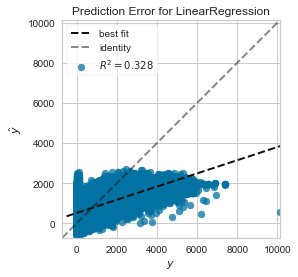

In [19]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [20]:
#Time series
time_pred_reg_lr = reg_base.predict(x_test_reg_series)

time_pred_series_reg_lr = pd.Series(time_pred_reg_lr)
time_real_series_reg_lr = pd.Series(y_test_reg_series)

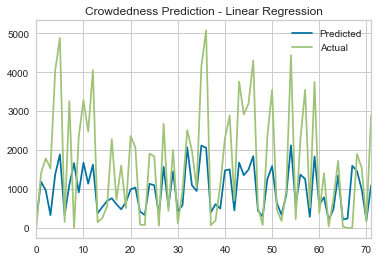

In [21]:
time_pred_series_reg_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_reg_lr.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [22]:
base_score = reg_base.score(x_eval_reg, y_eval_reg)

y_pred_base = reg_base.predict(x_eval_reg)
base_mse = mean_squared_error(y_pred_base, y_eval_reg)

print("R^2 Score: ", base_score)
print("MSE: ", base_mse)
print("RMSE: ", np.sqrt(base_mse))

R^2 Score:  0.25444067395166337
MSE:  460597.93438970414
RMSE:  678.6736582406187


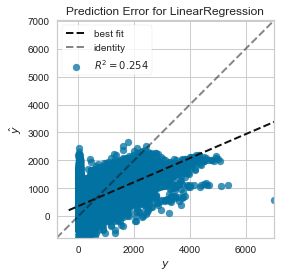

In [23]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [24]:
#Time series
time_pred_lr = reg_base.predict(x_series_reg)

time_pred_series_lr = pd.Series(time_pred_lr)
time_real_series_lr = pd.Series(y_series_reg)

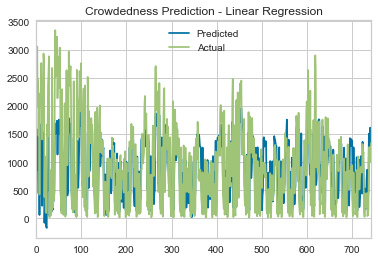

In [25]:
time_pred_series_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_lr.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Regressor <a name="regRFGModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Parameters
- *N-Estimators*: Number of trees in the model
- *criterion*: loss function
- *n_jobs*: The number of jobs to run in parallel for both fit and predict
- *random_state*: random_state is the seed used by the random number generator
- *bootstrap*: Whether bootstrap samples are used when building trees

#### Training

In [26]:
#Set parameters model
reg_rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True, 
                               oob_score=True)

In [27]:
#fit the model
reg_rfg.fit(x_train_reg, y_train_reg)

KeyboardInterrupt: 

#### Test

In [ ]:
#Score the model
reg_rfg_score = reg_rfg.score(x_test_reg, y_test_reg)

#Test
y_pred_reg_rfg = reg_rfg.predict(x_test_reg)
reg_rfg_mse = mean_squared_error(y_pred_reg_rfg, y_test_reg)

print("R^2 Score: ", reg_rfg_score)
print("MSE Test: ", reg_rfg_mse)
print("RMSE Test: ", np.sqrt(reg_rfg_mse))

In [ ]:
for i in range(10):
    print("Predicted: ", y_pred_reg_rfg[i], "Real: ", y_test_reg[i])

In [ ]:
#Feature importance
importance = reg_rfg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

In [ ]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [ ]:
#Time series
time_pred_reg_rfg = reg_rfg.predict(x_test_reg_series)

time_pred_series_reg_rfg = pd.Series(time_pred_reg_rfg)
time_real_series_reg_rfg = pd.Series(y_test_reg_series)

In [ ]:
time_pred_series_reg_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_reg_rfg.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
#Score the model
rfg_score = reg_rfg.score(x_eval_reg, y_eval_reg)

#Test
y_pred_rfg = reg_rfg.predict(x_eval_reg)
rfg_mse = mean_squared_error(y_pred_rfg, y_eval_reg)

print("R^2 Score: ", rfg_score)
print("MSE Test: ", rfg_mse)
print("RMSE Test: ", np.sqrt(rfg_mse))

In [ ]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
#Time series
time_pred_rfg = reg_rfg.predict(x_series_reg)

time_pred_series_rfg = pd.Series(time_pred_rfg)
time_real_series_rfg = pd.Series(y_series_reg)

In [ ]:
time_pred_series_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_rfg.plot(legend=True, label="Actual")
plt.show()

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [ ]:
xgb_reg = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=300, verbosity=1,
                          booster="gbtree", n_jobs=20, random_state=42)

In [ ]:
xgb_reg.fit(x_train_reg, y_train_reg)

#### Test

In [ ]:
reg_xgb_score = xgb_reg.score(x_test_reg, y_test_reg)

#Training
y_pred_reg_xgb = xgb_reg.predict(x_test_reg)
reg_xgb_mse = mean_squared_error(y_pred_reg_xgb, y_test_reg)

print("R^2 Score: ", reg_xgb_score)
print("MSE Test: ", reg_xgb_mse)
print("RMSE Test: ", np.sqrt(reg_xgb_mse))

In [ ]:
for i in range(10):
    print("Predicted: ", y_pred_reg_xgb[i], "Real: ", y_test_reg[i])

In [ ]:
#Feature importance
importance = xgb_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

In [ ]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [ ]:
#Time series
time_pred_reg_xgb = xgb_reg.predict(x_test_reg_series)

time_pred_series_reg_xgb = pd.Series(time_pred_reg_xgb)
time_real_series_reg_xgb = pd.Series(y_test_reg_series)

In [ ]:
time_pred_series_reg_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_reg_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
xgb_score = xgb_reg.score(x_eval_reg, y_eval_reg)

#Training
y_pred_xgb = xgb_reg.predict(x_eval_reg)
xgb_mse = mean_squared_error(y_pred_xgb, y_eval_reg)

print("R^2 Score: ", xgb_score)
print("MSE Test: ", xgb_mse)
print("RMSE Test: ", np.sqrt(xgb_mse))

In [ ]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
#Time series
time_pred_xgb = xgb_reg.predict(x_series_reg)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_reg)

In [ ]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### Lasso <a name="regABRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

#### Training

In [ ]:
lasso = LassoCV(n_jobs=50, random_state=42, n_alphas=5, normalize=True, precompute="auto", selection="random")

In [ ]:
lasso.fit(x_train_reg, y_train_reg)

#### Test

In [ ]:
reg_lasso_score=lasso.score(x_test_reg, y_test_reg)

y_pred_reg_lasso = lasso.predict(x_test_reg)
reg_lasso_mse = mean_squared_error(y_pred_reg_lasso, y_test_reg)

print("R^2 Sore: ", reg_lasso_score)
print("MSE: ", reg_lasso_mse)
print("RMSE: ", np.sqrt(reg_lasso_mse))

In [ ]:
for i in range(10):
    print("Predicted: ", y_pred_reg_lasso[i], "Real: ", y_test_reg[i])

In [ ]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [ ]:
#Time series
time_pred_reg_lasso = lasso.predict(x_test_reg_series)

time_pred_series_reg_lasso = pd.Series(time_pred_reg_lasso)
time_real_series_reg_lasso = pd.Series(y_test_reg_series)

In [ ]:
time_pred_series_reg_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_reg_lasso.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
lasso_score=lasso.score(x_eval_reg, y_eval_reg)

y_pred_lasso = lasso.predict(x_eval_reg)
lasso_mse = mean_squared_error(y_pred_lasso, y_eval_reg)

print("R^2 Sore: ", lasso_score)
print("MSE: ", lasso_mse)
print("RMSE: ", np.sqrt(lasso_mse))

In [ ]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
#Time series
time_pred_lasso = lasso.predict(x_series_reg)

time_pred_series_lasso = pd.Series(time_pred_lasso)
time_real_series_lasso = pd.Series(y_series_reg)

In [ ]:
time_pred_series_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_lasso.plot(legend=True, label="Actual")
plt.show()

## Classification Models <a name="classification"></a>

### Change numerical labels to categorical labels <a name="classCatVar"></a>

In [ ]:
low_split = TrainTest_df["CrowdednessCount"].quantile(.25)
mid_split = TrainTest_df["CrowdednessCount"].quantile(.5)
high_split = TrainTest_df["CrowdednessCount"].quantile(.75)

In [ ]:
clas_dict = TrainTest_df.to_dict("index")

for k, v in clas_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
clas_model_df = pd.DataFrame.from_dict(clas_dict, orient="index")

In [ ]:
series_dict = TimeSeries_df.to_dict("index")

for k, v in series_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
TimeSeries_df_clas = pd.DataFrame.from_dict(series_dict, orient="index")    

In [ ]:
TimeSeries_df_clas.head()

In [ ]:
train_df_clas = clas_model_df[clas_model_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date","index"])

test_df_clas = clas_model_df[clas_model_df["Date"].isin(test_set_dates)].reset_index().drop(columns=["index"])

In [ ]:
#Train
x_train_clas = train_df_clas.drop(["CrowdednessCount"], axis=1)
y_train_clas = train_df_clas["CrowdednessCount"]

#Test
x_test_clas = test_df_clas.drop(["CrowdednessCount", "Date"], axis=1)
y_test_clas = test_df_clas["CrowdednessCount"]

test_clas_series = test_df_clas[(test_df_clas["SensorLatitude"] == test_lat) & 
                              (test_df_clas["Date"] == test_set_dates[0])].reset_index()
x_test_clas_series = test_clas_series.drop(["CrowdednessCount", "Date", "index"], axis=1)
y_test_clas_series = test_clas_series["CrowdednessCount"]

#Time series
x_eval_clas = TimeSeries_df_clas.drop(["CrowdednessCount", "Date"], axis=1)
y_eval_clas = TimeSeries_df_clas["CrowdednessCount"]

sub_series_clas = TimeSeries_df_clas[(TimeSeries_df_clas["SensorLatitude"] == test_lat) & 
                           (TimeSeries_df_clas["Date"] >= eval_start_date) & 
                           (TimeSeries_df_clas["Date"] <= eval_end_date)].reset_index()

x_series_clas = sub_series_clas.drop(["CrowdednessCount", "Date","index"], axis=1)
y_series_clas = sub_series_clas["CrowdednessCount"]

### Baseline <a name="classBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Parameters
- *strategy*: "stratified” - generates predictions by respecting the training set’s class distribution.

#### Training

In [ ]:
clas_bas = DummyClassifier(strategy="stratified", random_state=42)

In [ ]:
clas_bas.fit(x_train_clas, y_train_clas)

#### Test

In [ ]:
y_pred_clas_bas = clas_bas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_bas))
print(classification_report(y_test_clas, y_pred_clas_bas))

In [ ]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_bas_clas = clas_bas.predict(x_test_clas_series)

time_pred_series_bas_clas = pd.Series(time_pred_bas_clas)
time_real_series_bas_clas = pd.Series(y_test_clas_series)

In [ ]:
time_pred_series_bas_clas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
y_pred_bas = clas_bas.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_bas))
print(classification_report(y_eval_clas, y_pred_bas))

In [ ]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_bas = clas_bas.predict(x_series_clas)

time_pred_series_bas = pd.Series(time_pred_bas)
time_real_series_bas = pd.Series(y_series_clas)

In [ ]:
time_pred_series_bas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Classifier <a name="classRFCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### Train

In [ ]:
clas_rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=50, random_state=42, 
                                  class_weight="balanced", oob_score="True")

In [ ]:
clas_rfc.fit(x_train_clas, y_train_clas)

#### Test

In [ ]:
y_pred_clas_rfc = clas_rfc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_rfc))
print(classification_report(y_test_clas, y_pred_clas_rfc))

In [ ]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_rfc_clas = clas_rfc.predict(x_test_clas_series)

time_pred_series_rfc_clas = pd.Series(time_pred_rfc_clas)
time_real_series_rfc_clas = pd.Series(y_test_clas_series)

In [ ]:
time_pred_series_rfc_clas.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
y_pred_rfc = clas_rfc.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_rfc))
print(classification_report(y_eval_clas, y_pred_rfc))

In [ ]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_rfc = clas_rfc.predict(x_series_clas)

time_pred_series_rfc = pd.Series(time_pred_rfc)
time_real_series_rfc = pd.Series(y_series_clas)

In [ ]:
time_pred_series_rfc.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc.plot(legend=True, label="Actual")
plt.show()

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

#### Training

In [ ]:
xgb_clas = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=12, 
                              learning_rate=0.1, booster="gbtree", n_jobs=50)

In [ ]:
xgb_clas.fit(x_train_clas, y_train_clas)

#### Test

In [ ]:
y_pred_clas_xgb = xgb_clas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_xgb))
print(classification_report(y_test_clas, y_pred_clas_xgb))

In [ ]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_clas_xgb = xgb_clas.predict(x_test_clas_series)

time_pred_series_clas_xgb = pd.Series(time_pred_clas_xgb)
time_real_series_clas_xgb = pd.Series(y_test_clas_series)

In [ ]:
time_pred_series_clas_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_clas_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
y_pred_xgb = xgb_clas.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_xgb))
print(classification_report(y_series_clas, y_pred_xgb))

In [ ]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_xgb = xgb_clas.predict(x_series_clas)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_clas)

In [ ]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### SVC 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

#### Training

In [ ]:
clas_svc = SVC(kernel="rbf", random_state=42, class_weight="balanced", C=0.5, decision_function_shape="ovo", gamma="auto")

In [ ]:
clas_svc.fit(x_train_clas, y_train_clas)

#### Test

In [ ]:
y_pred_clas_svc = clas_svc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_svc))
print(classification_report(y_test_clas, y_pred_clas_svc))

In [ ]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_clas_svc = clas_svc.predict(x_test_clas_series)

time_pred_series_clas_svc = pd.Series(time_pred_clas_svc)
time_real_series_clas_svc = pd.Series(y_test_clas_series)

In [ ]:
time_pred_series_clas_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_clas_svc.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [ ]:
y_pred_svc = clas_svc.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_svc))
print(classification_report(y_series_clas, y_pred_svc))

In [ ]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [ ]:
#Time series
time_pred_svc = clas_svc.predict(x_series_clas)

time_pred_series_svc = pd.Series(time_pred_svc)
time_real_series_svc = pd.Series(y_series_clas)

In [ ]:
time_pred_series_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_svc.plot(legend=True, label="Actual")
plt.show()

### Logistic Regression
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

#### Training

#### Test

#### Evaluation